# Kontrolna točka 1 - Priprema i vizualizacija podataka

## Učitavanje podataka u Pandas Dataframe


In [1]:
import xml.etree.ElementTree as ET
import pandas as pd
from bs4 import BeautifulSoup
import os
import re

In [2]:
#custom SGM file parser class taken from this article: https://dzlab.github.io/nlp/2018/11/17/parsing-xml-into-dataframe/
from datetime import datetime
from lxml import objectify

class ReutersSGMLParser():
    """A helper class for parsing Reuters-21578 XGML file formats"""
    def __init__(self):
        self.bad_char_pattern = re.compile(r"&#\d*;")
        self.document_pattern = re.compile(r"<REUTERS.*?<\/REUTERS>", re.S)
        self.date_pattern = re.compile(r'[0-9]+-[A-Z]{3}-[0-9]{4} *[0-9]{2}:[0-9]{2}:[0-9]{2}\.[0-9]+')

    def empty_row(self):
        """Get an empty rows which can be transformed into a dataframe"""
        rows = {
            'old_id'     : [],
            'new_id'     : [],
            'has_topics' : [],
            'date'       : [],
            'topics'     : [],
            'places'     : [],
            'people'     : [],
            'orgs'       : [],
            'exchanges'  : [],
            'companies'  : [],
            'title'      : [],
            'dateline'   : [],
            'body'       : [],
            'author'     : [],
            'cgi_split'  : [],
            'lewis_split': []
        }
        return rows

    def get_text(self, elem, tagname, d_tag = False):
        """Get the text of a tag or empty string"""
        txt = getattr(elem, tagname, '')
        if txt == '':
            return ''
        if d_tag:
            txt = txt.D
        txt = txt.text.strip()
        return txt

    def get_date(self, elem, tagname):
        """Get the datetime of a tag or empty string"""
        date_str = getattr(elem, tagname, '')
        if date_str == '':
            return ''
        date_str = date_str.text.strip()
        try:
            date_str = self.date_pattern.findall(date_str)[0]
        except IndexError as ie:
            print('Cannot find date patter in: %s' % date_str)
            return ''
        date = datetime.strptime(date_str, '%d-%b-%Y %H:%M:%S.%f')
        return date

    def parse_header(self, rows, doc):
        """parse the header.
        e.g. <REUTERS TOPICS="YES" LEWISSPLIT="TRAIN" CGISPLIT="TRAINING-SET" OLDID="5544" NEWID="1">"""
        items = dict(doc.items())
        rows[   'old_id'  ].append(items.get('OLDID', ''))
        rows[   'new_id'  ].append(items.get('NEWID', ''))
        rows[ 'has_topics'].append(bool(items.get('TOPICS', '')))
        rows[ 'cgi_split' ].append(items.get('CGISPLIT', ''))
        rows['lewis_split'].append(items.get('LEWISSPLIT', ''))

    def parse_string(self, str):
        # remove bad characters
        xml_data = self.bad_char_pattern.sub('', str)
        # find documents
        documents = self.document_pattern.findall(xml_data)
        # parse document's elements
        rows = self.empty_row()
        for doc in documents:
            xml_doc = objectify.fromstring(doc)
            # parse attributes of the header
            self.parse_header(rows, xml_doc)
            # read DATE
            rows[  'date'  ].append(self.get_date(xml_doc, 'DATE'))
            # read TOPICS
            rows[  'topics'  ].append(self.get_text(xml_doc, 'TOPICS', True))
            # read PLACES
            rows[  'places'  ].append(self.get_text(xml_doc, 'PLACES', True))
            # read PEOPLE
            rows[ 'people'  ].append(self.get_text(xml_doc, 'PEOPLE', True))
            # read ORGS
            rows[ 'orgs'  ].append(self.get_text(xml_doc, 'ORGS', True))
            # read EXCHANGES
            rows[ 'exchanges'  ].append(self.get_text(xml_doc, 'EXCHANGES', True))
            # read COMPANIES
            rows[ 'companies'  ].append(self.get_text(xml_doc, 'COMPANIES', True))
            # read the TEXT tag
            text = xml_doc.TEXT
            rows[ 'title'  ].append(self.get_text(text, 'TITLE'))
            rows['dateline'].append(self.get_text(text, 'DATELINE'))
            rows[  'body'  ].append(self.get_text(text, 'BODY'))
            rows[  'author'  ].append(self.get_text(text, 'AUTHOR'))
        return rows

    def parse(self, path):
        """parse a file from the Reuters dataset
        """
        # open xml file
        xml_data = ''
        try:
            xml_data = open(path, 'r', encoding="utf-8").read()
        except UnicodeDecodeError as ude:
            print('Failed to read %s as utf-8' % path)
            lines = []
            for line in open(path, 'rb').readlines():
                line = line.decode('utf-8','ignore') #.encode("utf-8")
                lines.append(line)
            xml_data = '\n'.join(lines)
        return self.parse_string(xml_data) 

In [3]:
parser = ReutersSGMLParser()
data = parser.empty_row()

reuters_path=os.path.join(os.getcwd(), 'reuters21578')

filepaths=[os.path.join(reuters_path, filename) for filename in os.listdir(reuters_path) if filename.endswith('.sgm')]

for path in  filepaths:
    # parse current document
    rows = parser.parse(path)
    # append rows into dataset
    for key in data.keys():
        data[key] = data[key] + rows[key]

reuters_original = pd.DataFrame(data, columns=data.keys())
#df = df.astype(dtype= {"date":"datetime64[]"})


Failed to read c:\Users\magda\Desktop\diplomski-1.sem\uuzop\uuzop_projekt\reuters21578\reut2-017.sgm as utf-8
Cannot find date patter in: 31-MAR-1987 605:12:19.12


C:\Users\magda\AppData\Local\Temp/ipykernel_16584/1432737591.py:15: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  reuters_original = pd.DataFrame(data, columns=data.keys())


In [4]:
reuters_original.shape

(21578, 16)

In [5]:
reuters_original.columns.values

array(['old_id', 'new_id', 'has_topics', 'date', 'topics', 'places',
       'people', 'orgs', 'exchanges', 'companies', 'title', 'dateline',
       'body', 'author', 'cgi_split', 'lewis_split'], dtype=object)

Značajke:
- **oldid** - id dokumenta prema Reuters-22173 klasifikaciji
- **newid** - id koji dokumenta prema Reuters-21578 klasifikaciji
- **has_topics** - moguće vrijednosti su YES, NO i BYPASS, kako je dokument označen u originalnom skupu podataka
- **date** - datum i vrijeme nastanka dokumenta
- **topics** - lista tema kojima članak pripada
- **places** - lista mjesta kojima članak pripada
- **people** - lista ljudi kojima članak pripada
- **orgs** - lista kategorija orgs kojima članak pripada
- **exchanges** - lista razmjena kojima članak pripada
- **companies** - list kompanije kojima članak priprada
- **title** - naslov članka
- **dateline** - od kod je članak potekao, i dan u godini
- **body** - tijelo tj. tekst članka
- **author** - autor članka
- **cgisplit** - moguće vrijednosti su [TRAINING-SET, PUBLISHED-TESTSET] ovisno o tome za što se članak koristi u eksperimentima  u izvješćima HAYES89 i HAYES90b
- **lewissplit** - moguće vrijednosti su [TRAINING, TEST, NOT_USED] ovisno o tome za što se članak koristio u eksperimentima u izvješćima: LEWIS91d (poglavlja 9 i 10), LEWIS92b, LEWIS92e i LEWIS94b

In [6]:
reuters_original.head(n=10)

,old_id,new_id,has_topics,date,topics,places,people,orgs,exchanges,companies,title,dateline,body,author,cgi_split,lewis_split
0,5544,1,True,1987-02-26 15:01:01.790,cocoa,el-salvador,,,,,BAHIA COCOA REVIEW,"SALVADOR, Feb 26 -",Showers continued throughout the week in\nthe ...,,TRAINING-SET,TRAIN
1,5545,2,True,1987-02-26 15:02:20.000,,usa,,,,,STANDARD OIL <SRD> TO FORM FINANCIAL UNIT,"CLEVELAND, Feb 26 -",Standard Oil Co and BP North America\nInc said...,,TRAINING-SET,TRAIN
2,5546,3,True,1987-02-26 15:03:27.510,,usa,,,,,TEXAS COMMERCE BANCSHARES <TCB> FILES PLAN,"HOUSTON, Feb 26 -",Texas Commerce Bancshares Inc's Texas\nCommerc...,,TRAINING-SET,TRAIN
3,5547,4,True,1987-02-26 15:07:13.720,,usa,,,,,TALKING POINT/BANKAMERICA <BAC> EQUITY OFFER,"LOS ANGELES, Feb 26 -",BankAmerica Corp is not under\npressure to act...,"by Janie Gabbett, Reuters",TRAINING-SET,TRAIN
4,5548,5,True,1987-02-26 15:10:44.600,grain,usa,,,,,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,"WASHINGTON, Feb 26 -",The U.S. Agriculture Department\nreported the ...,,TRAINING-SET,TRAIN
5,5549,6,True,1987-02-26 15:14:36.410,veg-oil,argentina,,,,,ARGENTINE 1986/87 GRAIN/OILSEED REGISTRATIONS,"BUENOS AIRES, Feb 26 -",Argentine grain board figures show\ncrop regis...,,TRAINING-SET,TRAIN
6,5550,7,True,1987-02-26 15:14:42.830,,usa,,,,,RED LION INNS FILES PLANS OFFERING,"PORTLAND, Ore., Feb 26 -",Red Lion Inns Limited Partnership\nsaid it fil...,,TRAINING-SET,TRAIN
7,5551,8,True,1987-02-26 15:15:40.120,,usa,,,,,USX <X> DEBT DOWGRADED BY MOODY'S,"NEW YORK, Feb 26 -",Moody's Investors Service Inc said it\nlowered...,,TRAINING-SET,TRAIN
8,5552,9,True,1987-02-26 15:17:11.200,earn,usa,,,,,CHAMPION PRODUCTS <CH> APPROVES STOCK SPLIT,"ROCHESTER, N.Y., Feb 26 -",Champion Products Inc said its\nboard of direc...,,TRAINING-SET,TRAIN
9,5553,10,True,1987-02-26 15:18:06.670,acq,usa,,,,,COMPUTER TERMINAL SYSTEMS <CPML> COMPLETES SALE,"COMMACK, N.Y., Feb 26 -",Computer Terminal Systems Inc said\nit has com...,,TRAINING-SET,TRAIN


## Uklanjanje nebitnih značajki

Najprije pogledajmo kako pojedine značajke stoje s brojem jedinstvenih vrijedosti

has_topics         1
companies          1
cgi_split          2
lewis_split        3
orgs              32
exchanges         33
topics            83
people           111
places           115
author           345
dateline        7865
body           18783
title          20024
date           21577
old_id         21578
new_id         21578
dtype: int64


NameError: name 'plt' is not defined

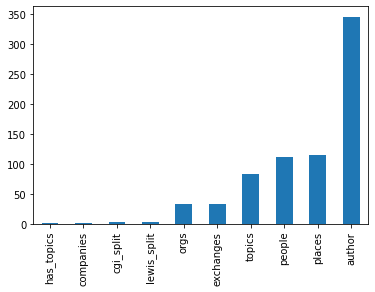

In [7]:
values_counts=reuters_original.nunique().sort_values()
print(values_counts)
values_counts.head(10).plot.bar()

# Add labels and title
plt.title('Categories and No of unique values for the 10 least monotone')
plt.xlabel('Categories')
plt.ylabel('No of unique values')

# Show the plot
plt.show()

Možemo ukloniti monotone značajke **old_id**, **new_id**, kao i značajke **has_topics** i **companies** koje imaju konstantnu vrijednost korz cijeli skup podataka, stoga ne nose nikakvu informaciju.


In [8]:
reuters2=reuters_original.copy()
del reuters2['old_id']
del reuters2['new_id']
del reuters2['companies']
del reuters2['has_topics']
print(reuters2.shape)
reuters2.head()

(21578, 12)


,date,topics,places,people,orgs,exchanges,title,dateline,body,author,cgi_split,lewis_split
0,1987-02-26 15:01:01.790,cocoa,el-salvador,,,,BAHIA COCOA REVIEW,"SALVADOR, Feb 26 -",Showers continued throughout the week in\nthe ...,,TRAINING-SET,TRAIN
1,1987-02-26 15:02:20.000,,usa,,,,STANDARD OIL <SRD> TO FORM FINANCIAL UNIT,"CLEVELAND, Feb 26 -",Standard Oil Co and BP North America\nInc said...,,TRAINING-SET,TRAIN
2,1987-02-26 15:03:27.510,,usa,,,,TEXAS COMMERCE BANCSHARES <TCB> FILES PLAN,"HOUSTON, Feb 26 -",Texas Commerce Bancshares Inc's Texas\nCommerc...,,TRAINING-SET,TRAIN
3,1987-02-26 15:07:13.720,,usa,,,,TALKING POINT/BANKAMERICA <BAC> EQUITY OFFER,"LOS ANGELES, Feb 26 -",BankAmerica Corp is not under\npressure to act...,"by Janie Gabbett, Reuters",TRAINING-SET,TRAIN
4,1987-02-26 15:10:44.600,grain,usa,,,,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,"WASHINGTON, Feb 26 -",The U.S. Agriculture Department\nreported the ...,,TRAINING-SET,TRAIN


Možemo pretpostaviti i da su značajke **date** i **dateline** uniformno raspoređene ili podaci nedostaju.

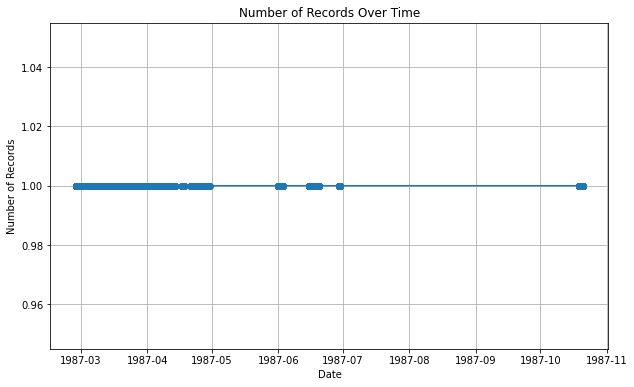

In [9]:
import matplotlib.pyplot as plt

reuters2['date'] = pd.to_datetime(reuters2['date'])

count_per_date = reuters2.groupby('date').size().reset_index(name='count')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(count_per_date['date'], count_per_date['count'], marker='o', linestyle='-')
plt.title('Number of Records Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Records')
plt.grid(True)
plt.show()

In [10]:
del reuters2['date']
del reuters2['dateline']
print(reuters2.shape)
reuters2.head()

(21578, 10)


,topics,places,people,orgs,exchanges,title,body,author,cgi_split,lewis_split
0,cocoa,el-salvador,,,,BAHIA COCOA REVIEW,Showers continued throughout the week in\nthe ...,,TRAINING-SET,TRAIN
1,,usa,,,,STANDARD OIL <SRD> TO FORM FINANCIAL UNIT,Standard Oil Co and BP North America\nInc said...,,TRAINING-SET,TRAIN
2,,usa,,,,TEXAS COMMERCE BANCSHARES <TCB> FILES PLAN,Texas Commerce Bancshares Inc's Texas\nCommerc...,,TRAINING-SET,TRAIN
3,,usa,,,,TALKING POINT/BANKAMERICA <BAC> EQUITY OFFER,BankAmerica Corp is not under\npressure to act...,"by Janie Gabbett, Reuters",TRAINING-SET,TRAIN
4,grain,usa,,,,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department\nreported the ...,,TRAINING-SET,TRAIN


## Vizualizacija podataka

Pogledajmo sada preostale značajke i pokušajmo ih vizualno predočiti

In [112]:
values_counts2=reuters2.nunique().sort_values()
print(values_counts2)

cgi_split          2
lewis_split        3
orgs              32
exchanges         33
topics            83
people           111
places           115
author           345
body           18783
title          20024
dtype: int64


### Places, People, Topics

#### Places

In [120]:
places_counts = reuters2[reuters2.places!='']['places'].value_counts().reset_index()
places_counts.columns = ['Place', 'Count']
places_counts = places_counts.sort_values(by='Count', ascending=False)
places_counts = places_counts.reset_index(drop=True)
places_counts.head(10)

,Place,Count
0,usa,11970
1,uk,1275
2,canada,923
3,japan,729
4,west-germany,399
5,france,350
6,australia,210
7,switzerland,181
8,belgium,177
9,brazil,168


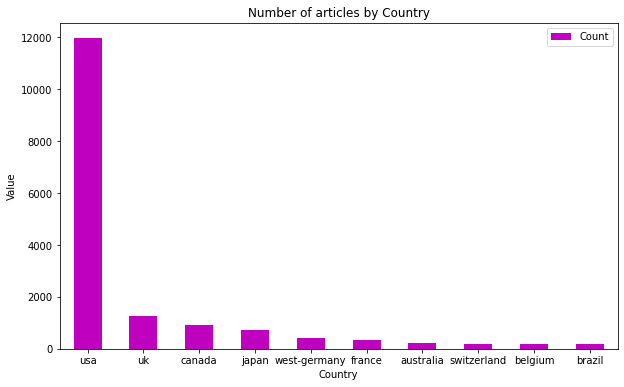

In [123]:
places_counts.head(10).plot.bar(x='Place', y='Count', rot=0, title='Number of articles by Country', figsize=(10, 6), color='m')

# Add labels and show the plot
plt.xlabel('Country')
plt.ylabel('Value')
plt.show()

#### People

In [114]:
people_counts = reuters2[reuters2.people!='']['people'].value_counts().reset_index()
people_counts.columns = ['People', 'Count']
people_counts = people_counts.sort_values(by='Count', ascending=False)
people_counts = people_counts.reset_index(drop=True)
people_counts.head(10)

,People,Count
0,reagan,157
1,james-baker,142
2,nakasone,55
3,lawson,55
4,volcker,54
5,miyazawa,50
6,yeutter,49
7,lyng,39
8,stoltenberg,35
9,sumita,33


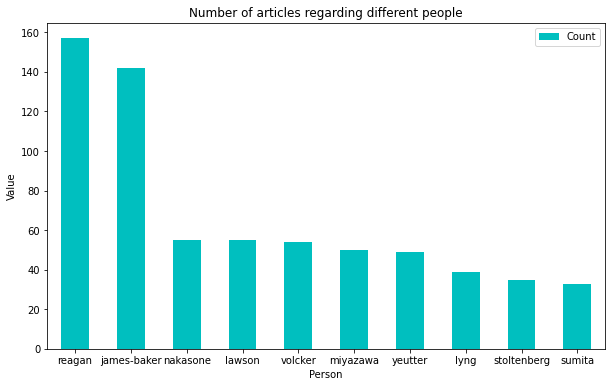

In [126]:
people_counts.head(10).plot.bar(x='People', y='Count', rot=0, title='Number of articles regarding different people', figsize=(10, 6), color='c')

# Add labels and show the plot
plt.xlabel('Person')
plt.ylabel('Value')
plt.show()

#### Topics

In [135]:
topics_series = reuters2['topics'].str.split('-').explode()

topic_counts = topics_series.value_counts().head(21)
topic_counts

            10211
earn         3972
acq          2423
money         859
fx            682
crude         543
grain         537
trade         473
interest      339
ship          209
supply        177
sugar         154
gnp           127
coffee        126
gold          123
oil            97
veg            94
gas            89
cpi            86
oilseed        81
cocoa          67
Name: topics, dtype: int64

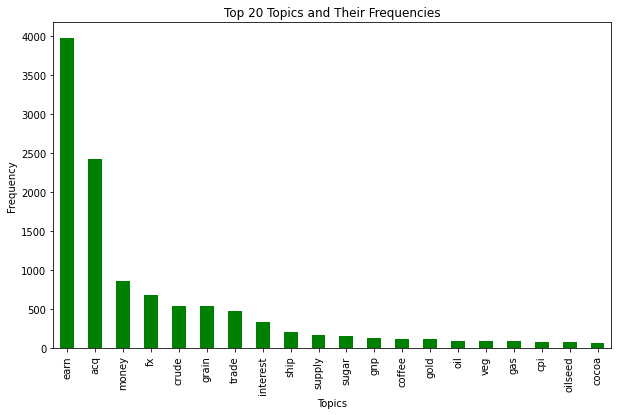

In [136]:
plt.figure(figsize=(10, 6))
topic_counts[1:21].plot(kind='bar', color='green')
plt.title('Top 20 Topics and Their Frequencies')
plt.xlabel('Topics')
plt.ylabel('Frequency')
plt.show()

### Body i Title - veličina

In [83]:
body_word_count = reuters2[reuters2.body!='']['body'].apply(lambda x: len(str(x).split()))
body_word_count.describe()

count    19043.000000
mean       134.813265
std        135.401069
min          1.000000
25%         56.000000
50%         89.000000
75%        166.000000
max       1668.000000
Name: body, dtype: float64

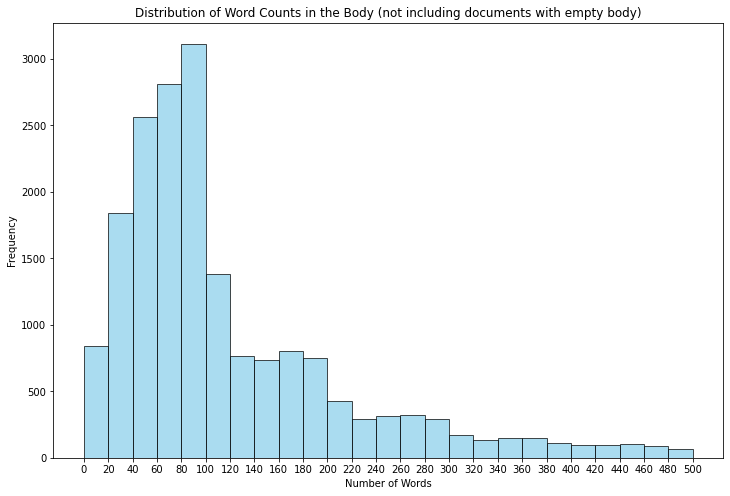

In [84]:
plt.figure(figsize=(12, 8))

bin_edges = list(range(0,501,20))

plt.hist(body_word_count, bins=bin_edges, color='skyblue', edgecolor='black', label='Sky Blue', alpha=0.7, align='mid')

plt.title('Distribution of Word Counts in the Body (not including documents with empty body)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.xticks(bin_edges)

plt.show()

In [85]:
title_word_count = reuters2[reuters2.title!='']['title'].apply(lambda x: len(str(x).split()))
title_word_count.describe()

count    20841.000000
mean         7.277530
std          1.979365
min          1.000000
25%          6.000000
50%          7.000000
75%          8.000000
max         26.000000
Name: title, dtype: float64

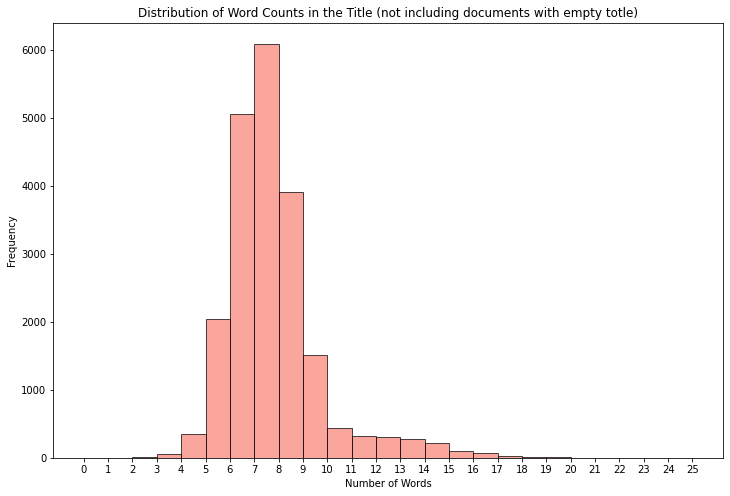

In [86]:
plt.figure(figsize=(12, 8))

bin_edges = list(range(0,26,1))

plt.hist(title_word_count, bins=bin_edges, color='salmon', edgecolor='black', label='Sky Blue', alpha=0.7, align='mid')

plt.title('Distribution of Word Counts in the Title (not including documents with empty totle)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.xticks(bin_edges)

plt.show()

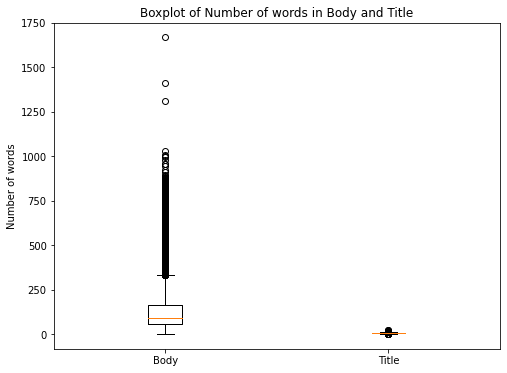

In [87]:
plt.figure(figsize=(8, 6))
plt.boxplot([body_word_count, title_word_count], labels=['Body', 'Title'])

# Add labels and title
plt.title('Boxplot of Number of words in Body and Title')
plt.ylabel('Number of words')

# Show the plot
plt.show()

## Pretprocesuiranje u oblik pogodan modelu

U radu se uspoređuju performanse SVM klasifikatora u kombinaciji s tri različite jezgrene funkcije - u radu predstavljeni SSK (String Subsequence Kernel) i klasični pristupi reprezentaciji teksta NGK (N-Gram Kernel) i WK (Word Kernel tj. Bag-of-Words pristup).

Pretprocesuiranje - bitni su samo topics i body
Topics - unnest, i ostaviti samo dokumente sa temema - "earn", "acq", "crude" i "corn"/"grain"
Body - ukloniti interpunkcije - .?! zamijeniti razmacima, ostale interpukcije samo ukloniti 
     - ukloniti stop rijeci - the an and ...

In [16]:
tc=reuters_original['topics'].value_counts()
tc.head(30)

                10211
earn             3972
acq              2423
money-fx          682
crude             543
grain             537
trade             473
interest          339
ship              209
money-supply      177
sugar             154
gnp               127
coffee            126
gold              123
veg-oil            94
cpi                86
oilseed            81
cocoa              67
copper             62
reserves           62
bop                60
livestock          58
ipi                57
jobs               57
alum               53
iron-steel         52
nat-gas            51
dlr                46
rubber             42
gas                38
Name: topics, dtype: int64

In [17]:

#keep only topics and body fields from the original dataset
reuters_processed=reuters_original[['topics', 'body']].copy()

#for documents with more topics separate the topics into individual records

#reuters_processed['topics'] = reuters_processed['topics'].str.split('-')
#reuters_processed = reuters_processed.explode('topics')

#only keep documents labeled as one of the 4 classes considered in the paper
topics_of_interest = ['earn', 'acq', 'crude', 'corn']
reuters_processed = reuters_processed[reuters_processed['topics'].isin(topics_of_interest)]


In [19]:
topic_counts=reuters_processed['topics'].value_counts()
print(topic_counts)

earn     3972
acq      2423
crude     543
corn        9
Name: topics, dtype: int64


In [21]:
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def preprocess_text(text):
    '''replaces punctuation and stopwords with spaces, turns everything to lowercase, removes possible multiple spaces'''
    # replace all punctuation with a space
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    text = text.translate(translator)
    
    # tokenize the text
    tokens = word_tokenize(text.lower())  # Convert to lowercase for consistency
    
    # replace all stop words with space
    stop_words = set(stopwords.words('english'))
    tokens = [' ' if word in stop_words else word for word in tokens]
    
    # Join the tokens back into a string
    processed_text = ' '.join(tokens)

    # replace multiple contiguous spaces with a single space
    processed_text = ' '.join(processed_text.split())
    
    return processed_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\magda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\magda\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [22]:
#process the body field
reuters_processed['body'] = reuters_processed['body'].apply(preprocess_text)

#remove all records with empty body
reuters_processed = reuters_processed[reuters_processed.body!='']
reuters_processed.to_csv("data/preprocessed.csv")
topic_counts_final=reuters_processed['topics'].value_counts()
print(topic_counts_final)

earn     3761
acq      2186
crude     483
corn        8
Name: topics, dtype: int64


split used in experiments: earn 152 (40); acq 114 (25); crude 76 (15); corn 38 (10)

for corn - since no data- well do 6(2)